In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

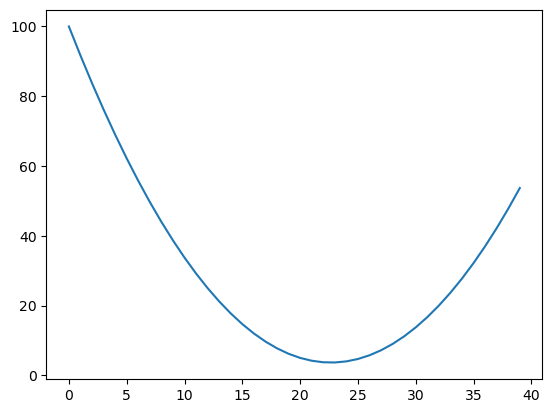

In [4]:
xs = np.arange(-5, 5,0.25)
ys = f(xs)
plt.plot(ys)

In [5]:
h = 0.000000001
x = 2/3
(f(x+h) - f(x))/h


0.0

In [6]:
a = 2.0
b = -3.0
c=10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0000001
# inputs
a = 2.0
b = -3.0
c=10.0

d1 = a*b+c
#a +=h
b +=h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0000002
slope 1.9999999967268423


In [265]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
        
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only support int/float powers for now'
        out = Value(self.data ** other, (self,), f"**{other}", '**')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**(-1)
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x =math.exp(self.data * 2)
        t = (x - 1) / (x+1)
        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out = Value(t, (self,), 'tanh')
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.
        for node in reversed(topo):
            node._backward()


In [190]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L # L = (a * b + c) * f

Value(data=-8.0)

In [191]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record' )
        if n._op:
            dot.node(name = uid+ n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
                

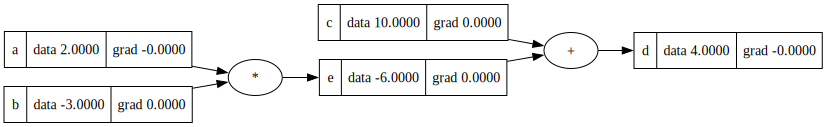

In [141]:
draw_dot(d)

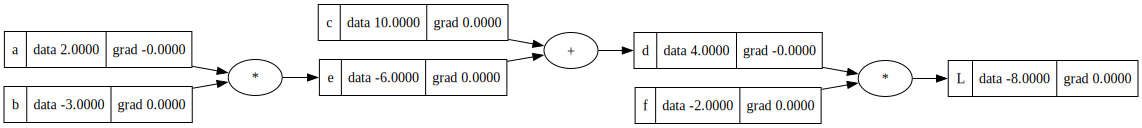

In [140]:
draw_dot(L)

In [142]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print(( L2 - L1)/h)

lol()

6.000000000021544


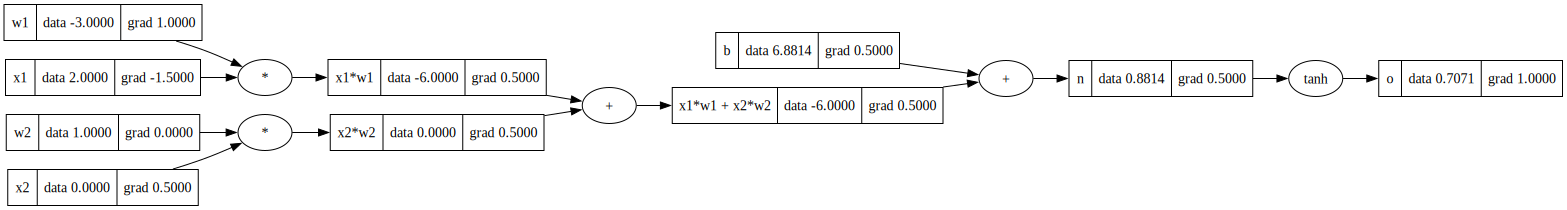

In [224]:
# input x1, x2
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label='x2')
# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.88137, label = 'b')
# x1*w1 + x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'
o=n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [144]:
# back-propagation: 
#o.grad = 1.
# do/dn = 1 - tanh(n) ** 2 = 1 - o**2
#n.grad = 0.5
#x1w1x2w2.grad = 0.5
#b.grad = 0.5
#x1w1.grad = 0.5
#x2w2.grad = 0.5
#w1.grad = 1.0
#w2.grad = 0.0
#x2.grad = 0.5
#x1.grad = -1.5

In [168]:
#o.grad = 1.0
#o._backward()
#n._backward()
#x1w1x2w2._backward()
#x1w1._backward()
#x2w2._backward()

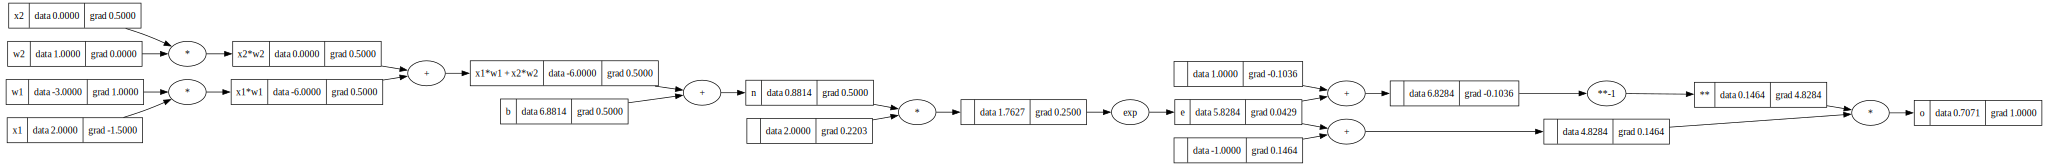

In [238]:
# input x1, x2
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label='x2')
# weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.88137, label = 'b')
# x1*w1 + x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'
# -----
e = (2*n).exp(); e.label =' e'
o = (e-1) / ( e+1)
# -----
o.label = 'o'
o.backward()
draw_dot(o)

In [215]:
import torch

In [239]:
# input x1, x2
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
# weight w1, w2
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
#bias of the neuron
b = torch.Tensor([6.881373]).double() ; b.requires_grad = True
# x1*w1 + x2*w2 +b
n = x1*w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071064519863152
x2 0.500000465559325
w2 0.0
x1 -1.500001396677975
w1 1.00000093111865


In [277]:
import random
class Neuron:
    def __init__(self, nin):
        # nin: size of the input vector
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    # calculate the output of a neuron
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        # nin: size of input vector
        # out: number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        # nin: size of input vector
        # nouts: number of neuron for each non-input layer
        sz = [nin] + nouts 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [315]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.7201378117563623)

In [280]:
len(n.parameters())

41

In [316]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


In [317]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip (ys, ypred))
loss

Value(data=6.09433577464681)

In [319]:
# gradient descent
for i in range(100):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip (ys, ypred))
    print(i, loss)

    # backward pass
    for p in n.parameters():
        p = 0.0
    loss.backward()
    
    # update weights and biases
    for p in n.parameters():
        p.data += -0.01 * p.grad
        


0 Value(data=6.09433577464681)
1 Value(data=5.264179900137641)
2 Value(data=2.8833567643705393)
3 Value(data=0.5660281503013347)
4 Value(data=0.3385426280446448)
5 Value(data=0.6040735603455775)
6 Value(data=0.6775971681342988)
7 Value(data=0.4022844856945975)
8 Value(data=0.2604260736531312)
9 Value(data=0.22841844442557857)
10 Value(data=0.1705104116167493)
11 Value(data=0.0895331666219107)
12 Value(data=0.029511184195431448)
13 Value(data=0.0056779413452755665)
14 Value(data=0.0006408731650769288)
15 Value(data=4.880073414742046e-05)
16 Value(data=3.402246239793431e-06)
17 Value(data=3.1781608518865304e-07)
18 Value(data=5.225613747326926e-08)
19 Value(data=1.535217973676744e-08)
20 Value(data=6.746334382720771e-09)
21 Value(data=3.74045271938489e-09)
22 Value(data=2.3720378322990344e-09)
23 Value(data=1.635840866880445e-09)
24 Value(data=1.2020059038603216e-09)
25 Value(data=9.71600169565488e-10)
26 Value(data=1.0868811510366426e-09)
27 Value(data=2.569992378126814e-09)
28 Value(da

In [320]:
n.parameters()

[Value(data=0.25875971868466235),
 Value(data=0.19152604894464326),
 Value(data=-11.165036182509878),
 Value(data=-3.1115164151398993),
 Value(data=-1.455664448989375),
 Value(data=-3.60065291369425),
 Value(data=-5.039961619774713),
 Value(data=-3.8937595673614185),
 Value(data=-5.02974615915556),
 Value(data=-5.121668942234211),
 Value(data=-1.0875097277104506),
 Value(data=-3.257904224361344),
 Value(data=-0.7455838234490993),
 Value(data=1.3846493942755473),
 Value(data=-1.401696225234818),
 Value(data=0.03583836172235942),
 Value(data=3.2803161067182787),
 Value(data=1.046244130004373),
 Value(data=0.38057646004837264),
 Value(data=0.7484709404965713),
 Value(data=-4.037024256346141),
 Value(data=-7.777852194703422),
 Value(data=-2.6231400717055813),
 Value(data=-2.7995776783289297),
 Value(data=-3.08667244103198),
 Value(data=2.731559049088513),
 Value(data=-10.980127932083706),
 Value(data=-10.41300065474853),
 Value(data=-8.032999817833993),
 Value(data=-7.451410485293003),
 Va

In [321]:
ypred

[Value(data=0.9999999993202898),
 Value(data=-0.9999999996686192),
 Value(data=-0.9999999996692543),
 Value(data=0.9999999992742112)]